In [284]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats

N = 14

DATASET = '../datasets/students_simple.csv'

data = pd.read_csv(DATASET)
columns = [data.columns[N % len(data.columns)], data.columns[N * N % len(data.columns)]]
columns
data = data[columns]
data.head()

,pages,bmi
0,24,3.533
1,32,2.623
2,24,2.875
3,24,3.375
4,60,3.000


## Расчёт корреляций

### Корреляция Фехнера 
$$corr = \frac{C-D}{C+D}$$
Где $C$ - количество отклонений от среднего в одном направлении, а $D$ в разных.

In [285]:
def fechner(x, y):
    assert len(x) == len(y)
    concordant = 0
    discordant = 0
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    for xi, yi in zip(x, y):
        x_sign = (xi - x_mean)
        y_sign = (yi - y_mean)
        
        if x_sign * y_sign > 0.0:
            concordant += 1
        elif x_sign * y_sign < 0.0:
            discordant += 1
    
    return (concordant - discordant) / (concordant + discordant)
fechner(data[columns[0]], data[columns[1]])

-0.4

### Пирсона + доверительный интервал
$$corr = \frac{\sum(x_i - x̄)(y_i - ȳ)}{ \sqrt{\sum(x_i - x̄)^2 \cdot \sum(y_i - ȳ)^2}}$$

In [286]:
def pirson(x, y):
    x_mean = np.mean(x)
    y_mean = np.mean(y)

    x = np.array(x)
    y = np.array(y)

    return np.sum((x - x_mean) * (y - y_mean)) / np.sqrt(np.sum(np.pow(x - x_mean, 2)) * np.sum(np.pow(y - y_mean, 2)))

print("корреляция", pirson(data[columns[0]], data[columns[1]]))

def pearson_confidence_interval(x, y, confidence: float = 0.90):
    r = pirson(x, y)
    n = len(x)

    import math
    
    z_r = 0.5 * math.log((1 + r) / (1 - r))
    z_se = 1 / math.sqrt(n - 3)
    z_alpha = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    z_lower = z_r - z_alpha * z_se
    z_upper = z_r + z_alpha * z_se
    
    def inverse_fisher(z):
        return (math.exp(2 * z) - 1) / (math.exp(2 * z) + 1)
    
    r_lower = inverse_fisher(z_lower)
    r_upper = inverse_fisher(z_upper)
    
    return r_lower, r_upper

pearson_confidence_interval(data[columns[0]], data[columns[1]])

корреляция -0.17949732800721208


(-0.5229552513675861, 0.21410761224511032)

### Спирмен

$$corr = 1 - \frac{6\sum{d_i^2}}{n(n^2 - 1)} $$
Где $d - $ разность рангов.
Данная корреляция применима в случае целочисленных признаков, в моём случае она не подходит и нужно использовать корреляцию Пирсона на отсортированных данных.

In [287]:
def spirmen(x, y):
    xx = list(enumerate(x))
    yy = list(enumerate(y))
    xx.sort(key=lambda el: -el[1])
    yy.sort(key=lambda el: -el[1])

    ranks = [0]
    t = 0
    for i in range(1, len(xx)):
        if xx[i][1] != xx[i - 1][1]:
            t += 1
        ranks.append(t)
    x = list(zip(xx, ranks))

    ranks = [0]
    t = 0
    for i in range(1, len(yy)):
        if yy[i][1] != yy[i - 1][1]:
            t += 1
        ranks.append(t)
    y = list(zip(yy, ranks))

    x.sort()
    y.sort()
    
    _, rx = zip(*x)
    _, ry = zip(*y)

    return pirson(rx, ry)
    

spirmen(data[columns[0]], data[columns[1]])

np.float64(-0.2588913669175301)

### Кенделл

Она оценивает вероятность того, что две переменные изменяются в одном направлении.
$$τₐ = \frac{2(C - D)}{(n(n-1))}$$

In [288]:
from scipy.stats import kendalltau
def kendall(x, y):
    xx = list(enumerate(x))
    yy = list(enumerate(y))
    xx.sort(key=lambda el: -el[1])
    yy.sort(key=lambda el: -el[1])

    ranks = [0]
    t = 0
    for i in range(1, len(xx)):
        if xx[i][1] != xx[i - 1][1]:
            t += 1
        ranks.append(t)
    x = list(zip(xx, ranks))

    ranks = [0]
    t = 0
    for i in range(1, len(yy)):
        if yy[i][1] != yy[i - 1][1]:
            t += 1
        ranks.append(t)
    y = list(zip(yy, ranks))

    x.sort()
    y.sort()
    
    _, rx = zip(*x)
    _, ry = zip(*y)
    r, _ = kendalltau(rx, ry)
    return r.item()

kendall(data[columns[0]], data[columns[1]])

-0.24423934661177393

#### Вывод
По всем тестам, признаки слабо коррелируют.

## Визуализация

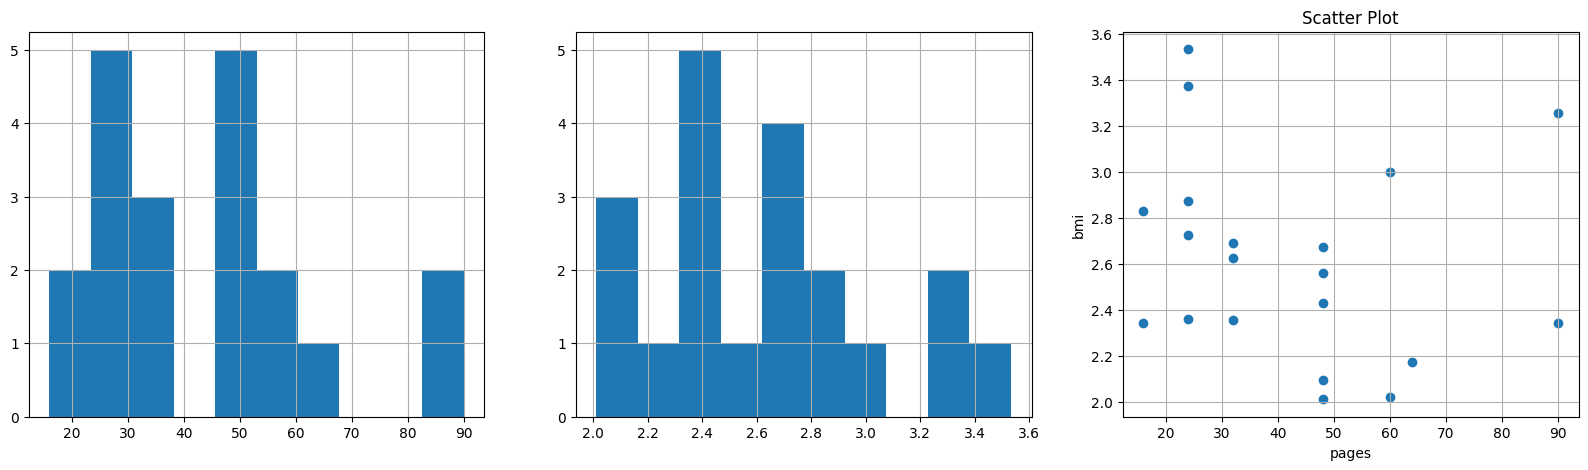

In [289]:
x = data[columns[0]]
y = data[columns[1]]


_, axs = plt.subplots(1, 3, figsize=(20, 5))

x.hist(ax=axs[0], bins=10)
y.hist(ax=axs[1], bins=10)

axs[2].scatter(x, y)
axs[2].set_xlabel('pages')
axs[2].set_ylabel('bmi')
axs[2].set_title('Scatter Plot')
axs[2].grid(True)

plt.show()

#### Вывод

Из за слишком малого набора данных, сложно утверждать об их распределении, однако, предположительно, оно схоже с нормальным, обладает положительной ассиметрией. Как видно из третьего графика, линейная зависимость не наблюдается.

## Регрессии

In [290]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

x = data[columns[1]].to_numpy().reshape(-1, 1)
y = data[columns[0]]
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

lin_reg = LinearRegression().fit(x, y)
sq_reg = LinearRegression().fit(np.concat([x, x ** 2], axis=1), y)
hyp_reg = LinearRegression().fit(1 / x, y)
log_reg = LinearRegression().fit(x, np.log(y))

lin_reg_pred = lin_reg.predict(x)
sq_reg_pred = sq_reg.predict(np.concat([x, x ** 2], axis=1))
hyp_reg_pred = hyp_reg.predict(1 / x)
log_reg_pred = np.exp(log_reg.predict(x))

def mse(x, y):
    return sum((x - y) * (x - y)) / len(x)

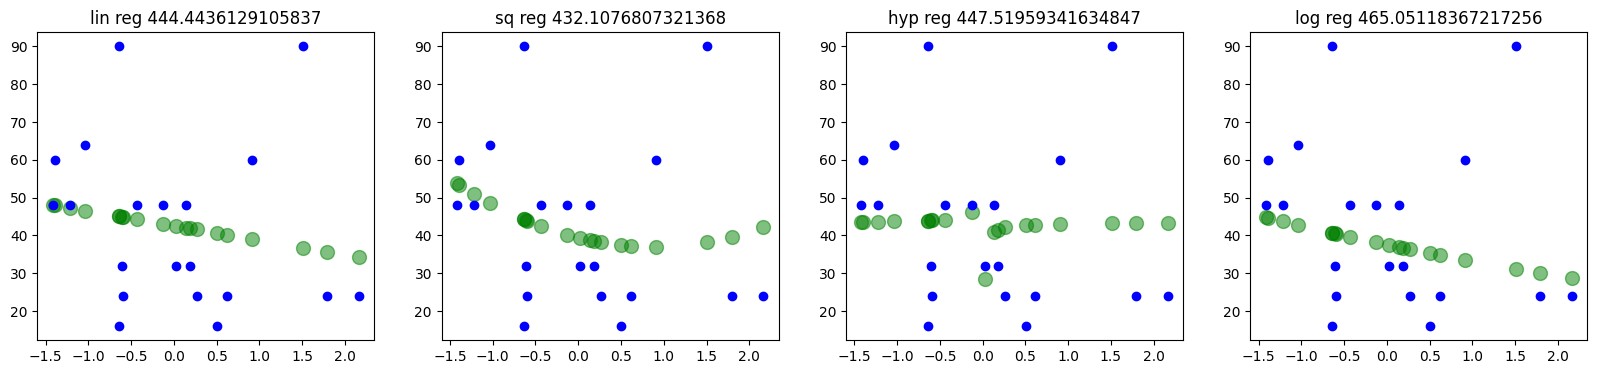

In [291]:
_, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].set_title(f"lin reg {mse(y, lin_reg_pred)}")
axs[0].scatter(x, lin_reg_pred, color="Green", s=100, alpha = 0.5)
axs[0].scatter(x, y, color="Blue")

axs[1].set_title(f"sq reg {mse(y, sq_reg_pred)}")
axs[1].scatter(x, sq_reg_pred, color="Green", s=100, alpha = 0.5)
axs[1].scatter(x, y, color="Blue")

axs[2].set_title(f"hyp reg {mse(y, hyp_reg_pred)}")
axs[2].scatter(x, hyp_reg_pred, color="Green", s=100, alpha = 0.5)
axs[2].scatter(x, y, color="Blue")

axs[3].set_title(f"log reg {mse(y, log_reg_pred)}")
axs[3].scatter(x, log_reg_pred, color="Green", s=100, alpha = 0.5)
axs[3].scatter(x, y, color="Blue")

plt.show()


#### Вывод

Модели слабо предсказывают результат.

## Проверка уравнения регрессии

##

In [292]:
def fisher(x, y):
    num = (x - y).std() ** 2
    den = y.std() ** 2
    return num / den

print(f"lin reg {fisher(lin_reg_pred, y)}")
print(f"sq reg {fisher(sq_reg_pred, y)}")

lin reg 0.9677807092382716
sq reg 0.9409190852977461


#### Вывод

Модели слабо предсказывают результат.